In [1]:
%load_ext autoreload
%autoreload 2

# Wasserstein Distance - what is it?

This notebook provides a simple illustration of how Wasserstein distance can be calculated given samples from two datasets.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.data import get_distribution
from labproject.utils import set_seed

set_seed(0)
plt.rcParams['figure.dpi'] = 150


In [3]:
#Helper plotting functions we use in this notebook

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

## Load data

We load in the toy mixture of Gaussians distribution in 2 dimensions as the base dataset.
We then define an augmented approximate distribution by changing the parameters of the mixture of gaussians.

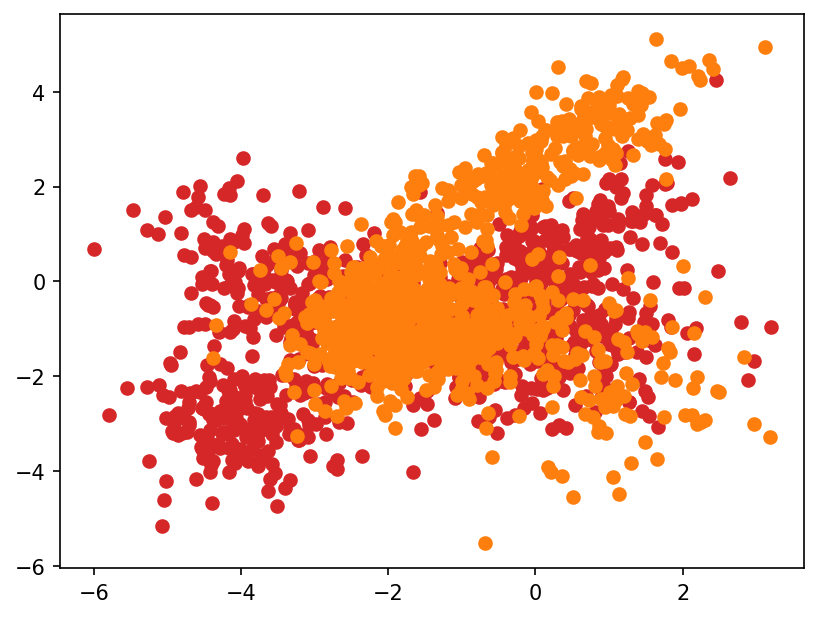

In [4]:
#Base distribution
toy_data = get_distribution("toy_2d")
datagen = toy_data()
data = datagen.sample(1000)

def update_toy_mog(datagen,means,covs,weights):
    datagen.means = means
    datagen.covs = covs
    datagen.weights = weights

    datagen.gaussians = [
        torch.distributions.MultivariateNormal(mean, covariance)
        for mean, covariance in zip(datagen.means, datagen.covariances)
    ]    
    return datagen

means2 = torch.Tensor([
            [0.0, 2.5],
            [-1.0, -0.5],
            [1.0, -2.0],
            [-2.0, -1.0],
        ])
            
covariances2 = torch.tensor(
                        [
                            [[1.0, 0.2], [0.2, 1.0]],
                            [[1.0, -0.7], [-0.7, 1.0]],
                            [[1.0, 0.0], [0.0, 1.0]],
                            [[0.5, 0.0], [0.0, 0.5]],
                        ]
                        )
weights2 = torch.tensor([0.3, 0.2, 0.1, 0.5])

#Augmented distribution
datagen2 = update_toy_mog(datagen,means2,covariances2,weights2)
data2 = datagen2.sample(1000)

#Plot the data
plt.scatter(data[:,0],data[:,1],color="C3")
plt.scatter(data2[:,0],data2[:,1],color="C1")

## Demonstration on subset

We take a small subset to demonstrate the transport problem.
Given $N$ samples from each distribution, we want to find the transport map to transport the samples from distribution 1, into the samples from distribution 2, minimizing the total distance of this transportation.

In other words, suppose we have $x = (x_1,...,x_N)$ and $y=(y_1,...,y_N)$ with $x_i\sim p_1$ and $y_j\sim p_2$. We define the **cost function** to be the pairwise distances with respect to a chosen norm $d(\cdot,\cdot)$, i.e.:
\begin{equation}
C = \begin{bmatrix}
d(x_1,y_1) &\dots& d(x_1,y_N) \\
\vdots &\ddots & \vdots\\
d(x_N,y_1) & \dots & d(x_N,y_{N}) 
\end{bmatrix}
\end{equation}

In the ideal case, we want to find a permutation $\pi \in \{0,1\}^{N\times N}$ that injectively maps the $x_i$'s to the $y_j$'s. We want the mapping $\pi$ that minimizes the cost, i.e. minimizing $\sum\limits_{ij}\pi_{ij}C_{ij}$.
Below we show the action of the map $\pi = I$, the identity matrix

tensor([[2.1614, 4.2141, 5.7055, 2.0034, 7.4913, 4.8794, 4.4335, 5.2918, 2.0234,
         2.3132],
        [1.0383, 1.8318, 3.3747, 1.1247, 5.0778, 2.6363, 1.6756, 3.0079, 0.8178,
         0.7740],
        [0.0609, 2.8801, 4.4264, 1.4048, 5.3957, 2.7919, 2.5926, 3.2028, 0.4049,
         0.2920],
        [1.7768, 3.5335, 5.0160, 1.3217, 7.0831, 4.4964, 3.8264, 4.9046, 1.5265,
         1.8634],
        [1.9722, 0.8979, 2.4432, 1.5200, 5.0491, 2.9121, 1.1665, 3.2116, 1.7089,
         1.7080],
        [1.9818, 0.8942, 2.4310, 1.5699, 4.9896, 2.8618, 1.1065, 3.1584, 1.7298,
         1.7165],
        [3.2032, 2.4213, 3.0358, 3.6411, 2.7947, 1.5464, 1.1749, 1.5427, 3.2601,
         2.9968],
        [3.1501, 1.7525, 2.6581, 1.8034, 6.8736, 4.7903, 2.9118, 5.0956, 2.7253,
         2.9576],
        [1.9892, 1.0879, 2.5046, 1.8880, 4.5493, 2.4478, 0.7246, 2.7305, 1.8273,
         1.7241],
        [2.2002, 5.0501, 6.6018, 3.1890, 6.6666, 4.1625, 4.7059, 4.5443, 2.4662,
         2.4672]])


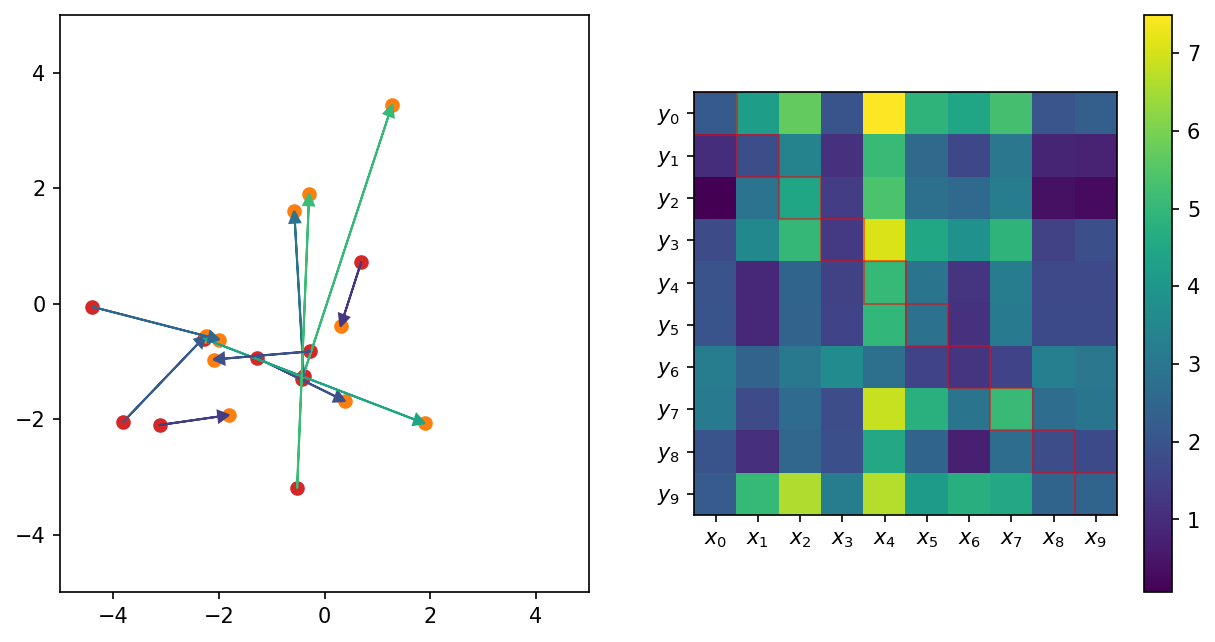

In [5]:
ndata = 10
plot_data = data[:ndata]
plot_data2 = data2[:ndata]
pairdist = torch.cdist(plot_data,plot_data2) #This is the cost matrix, with the norm being the euclidean distance between two points!
print(pairdist)
fig,axs = plt.subplots(1,2,figsize=(10,5))
colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,i,ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')
cmap = cbar.cmap




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,ind].item()/pairdist.max().item()))



Of course, this is only one permutation!

Let's randomly permute the labels $j$ and show the action of $\pi$ in this case.

tensor([2, 9, 6, 8, 1, 7, 4, 3, 5, 0])


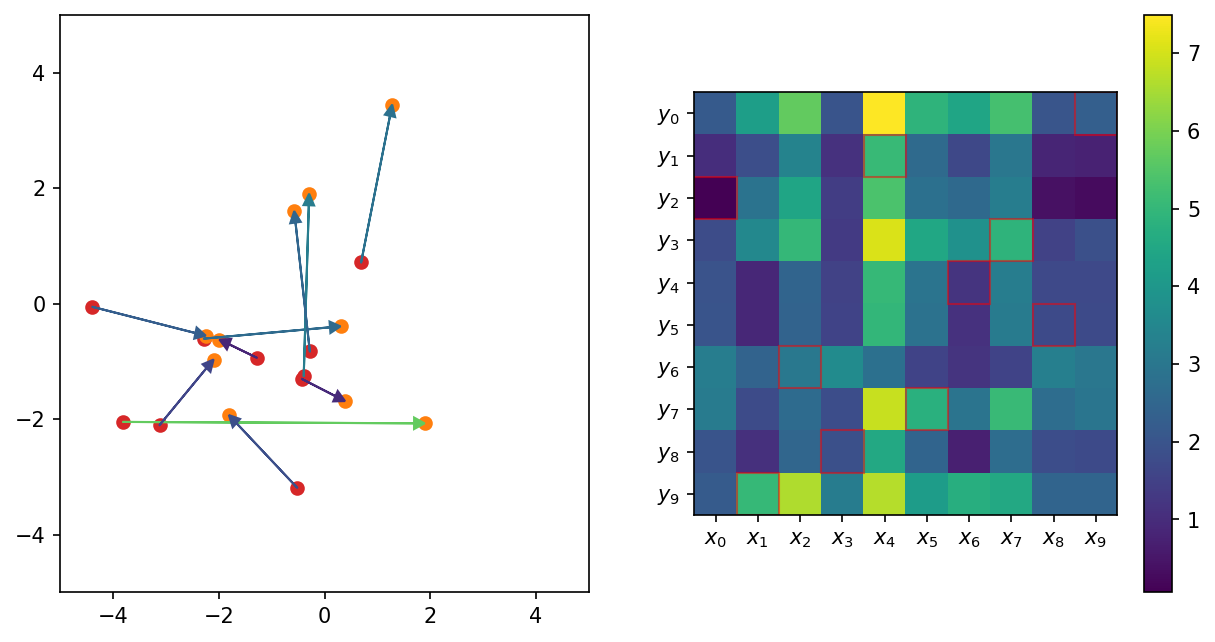

In [6]:
permutation = torch.randperm(plot_data2.size()[0])
print(permutation)
plot_data2_copy = plot_data2[permutation]
#pairdist = torch.cdist(plot_data,plot_data2)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))



## Selecting the best transport map

So, many choices are possible - the Wasserstein distance in this case is defined as the total cost $\sum\limits_{ij} \pi_{ij}C_{ij}$ of the best map $\pi^{*}$. Therefore, **in order to calculate the Wasserstein distance, we need to find the best transport map!!**

This is a non-trivial problem. Luckily, the problem of finding a permutation map already exists under the name of the **assignment problem**. There exists an algorithm to solve this assignment problem exactly, known as the **Hungarian method**. This is implemented in the toolbox, and you can find the code with sources in `wasserstein_kuhn.py`. Let's apply it here and see what map we get!

tensor([8, 9, 0, 3, 1, 6, 4, 2, 7, 5])
Wasserstein distance between x and y:  1.853010993078351


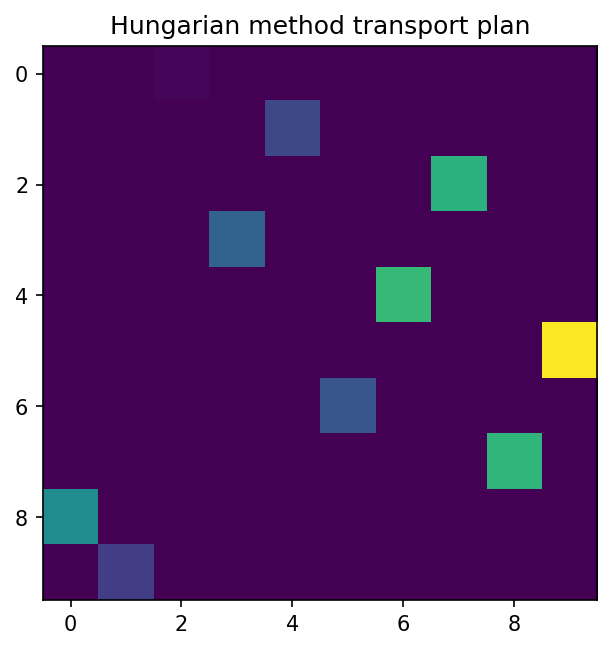

In [9]:
cost,transport = kuhn_transport(plot_data,plot_data2,norm=2)
plt.imshow(transport.T)
plt.title("Hungarian method transport plan")
print(transport.argmax(dim=1))
print("Wasserstein distance between x and y: " , cost.item())

### Evaluation

The plot above shows that we indeed found a permutation (note that we plot the cost associated with each element, rather than the permutation itself, which is why the non-zero values are not equal). 
Now, let's visualize how this transportation looks like on our data samples.

tensor([8, 9, 0, 3, 1, 6, 4, 2, 7, 5])


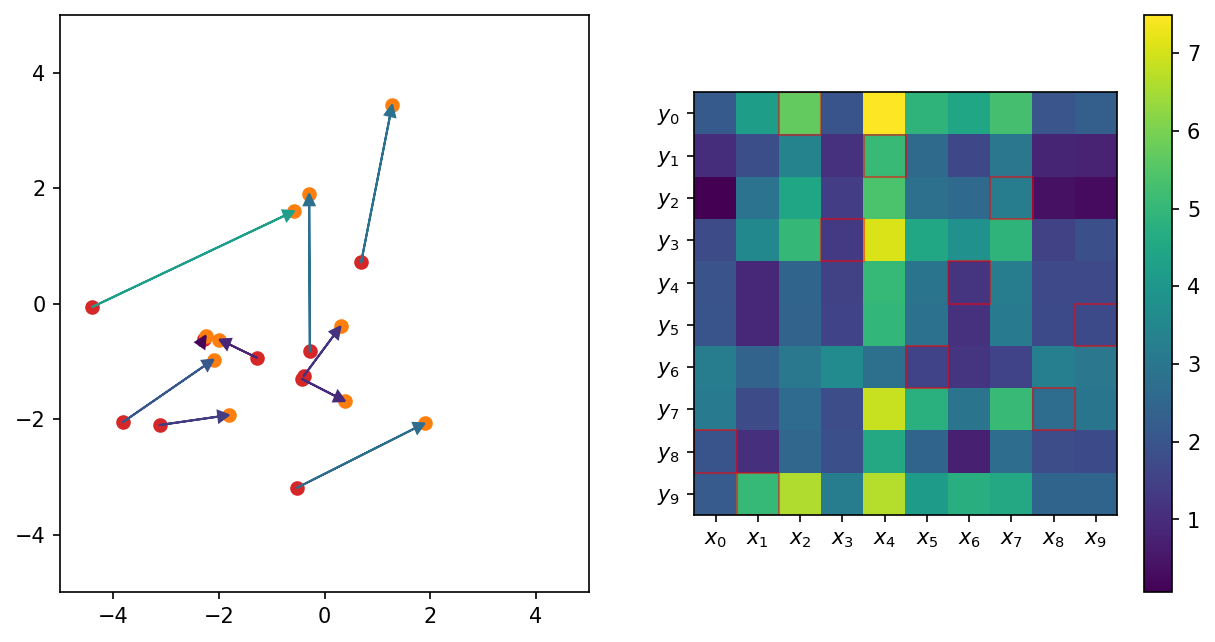

In [8]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
# for i in range(ndata):
#     for j in range(ndata):
#         axs[0].arrow(plot_data[i,0],plot_data[i,1],plot_data2[j,0]-plot_data[i,0],plot_data2[j,1]-plot_data[i,1],head_width=0.2,
#                       head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[i,j].item()/pairdist.max().item()),
#                       alpha=transport[i,j].item()/transport.max().item())



## Optimal Transport Plan

This plan looks promising! First, the distances are much smaller upon visual inspection. Another important feature is that none of the lines cross - indeed one can show that an optimal transport plan with the euclidean distance in $\mathbb{R}^{2}$ will not produce any crossing lines.

## Other metrics

The Wasserstein computation is typically defined using the standard $L^p$ norms in $\mathbb{R}^{d}$ - however, any valid norm on $\mathbb{R}^{d}$ computed in this way leads to a valid metric between probabilities. For fun, let's find the optimal transport map with a unique metric called the **railway metric**. The railway metric is defined as having to travel along a radial line towards a central point (your city's big train station), so to get from point $A$ to point $B$, you can only go first to the origin from A, and then back out through B. The exception is when A and B are on the same line, and then you can travel directly from A to B.

Let's see how this is calculated

(-2.0, 3.0)

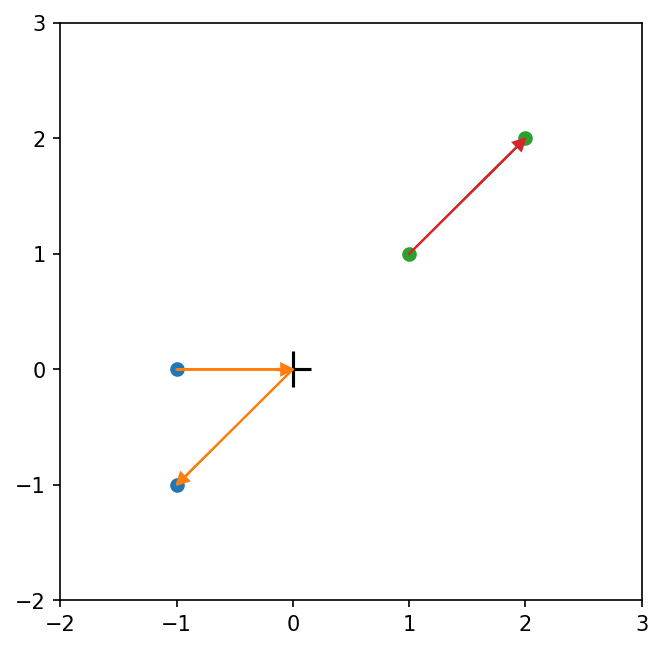

In [9]:
def railway_metric(x,y):
    if torch.abs(torch.dot(x,y) - torch.norm(x) * torch.norm(y)) < 1e-9:
        return torch.norm(x-y)
    else:
        return torch.norm(x) + torch.norm(y)
    
def los_angeles_metric(x,y):
    return torch.norm(x[0]-y[0]) + torch.norm(x[1]) + torch.norm(y[1])

rpoints = torch.Tensor([[0.0,0.0],[1.0,1.0],[2.0,2.0],[-1.0,0.0],[-1.0,-1.0]])

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(rpoints[1:3,0],rpoints[1:3,1],color="C2")
ax.scatter(rpoints[3:,0],rpoints[3:,1],color="C0")
ax.scatter(rpoints[0,0],rpoints[0,1],marker = "+",color="black",s=300)

ax.arrow(rpoints[1,0],rpoints[1,1],rpoints[2,0]-rpoints[1,0],rpoints[2,1]-rpoints[1,1],head_width=0.1, head_length=0.1,length_includes_head=True,color = "C3")
ax.arrow(rpoints[3,0],rpoints[3,1],rpoints[0,0]-rpoints[3,0],rpoints[0,1]-rpoints[3,1],head_width=0.1, head_length=0.1,length_includes_head=True,color = "C1")
ax.arrow(rpoints[0,0],rpoints[0,1],rpoints[4,0]-rpoints[0,0],rpoints[4,1]-rpoints[0,1],head_width=0.1, head_length=0.1,length_includes_head=True,color = "C1")

ax.set_xlim(-2,3)
ax.set_ylim(-2,3)

Now, let's calculate the optimal transport map with this distance metric!

tensor(3.9434, dtype=torch.float64)
tensor([5, 6, 0, 1, 7, 2, 3, 4, 8, 0])


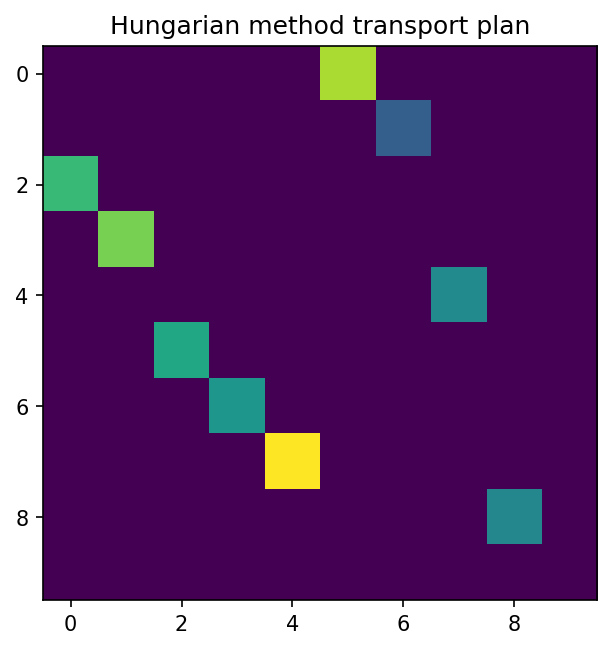

In [10]:
cost,transport = kuhn_transport(plot_data,plot_data2,norm=railway_metric)
print(cost)
plt.imshow(transport)
plt.title("Hungarian method transport plan")
permutation = transport.argmax(dim=1)
print(permutation)

Now let's visualize this transport plan.

To avoid confusion, we still plot the transportation directly between the two points, but the distances are calculated by going to the origin first!

tensor([5, 6, 0, 1, 7, 2, 3, 4, 8, 0])


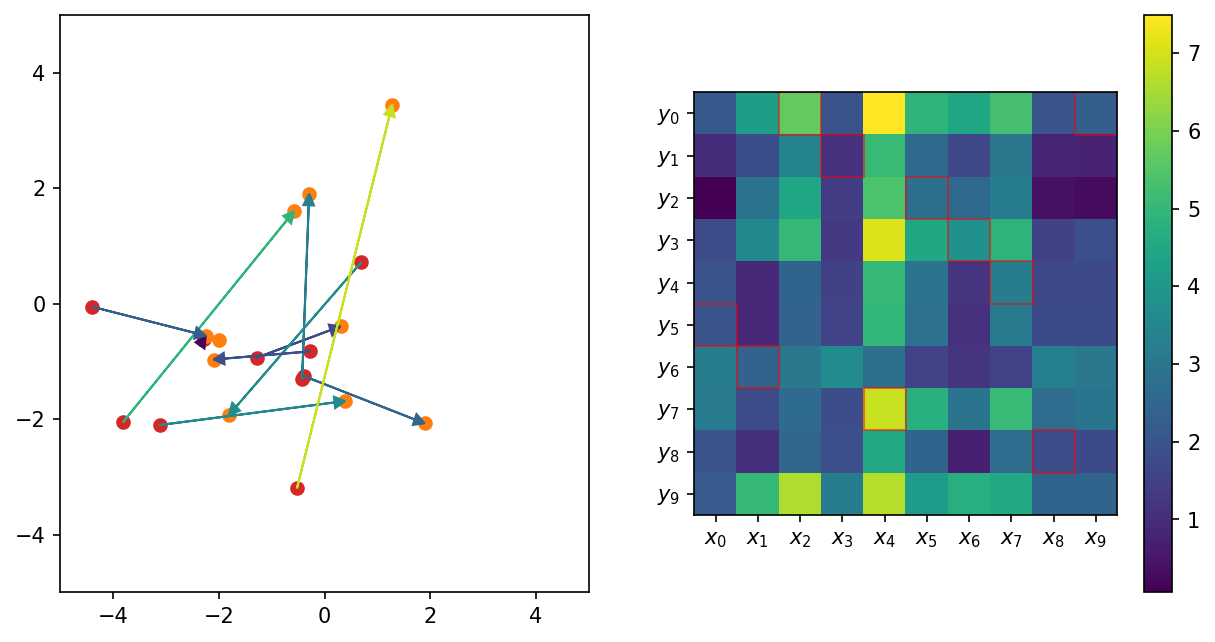

In [11]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
# for i in range(ndata):
#     for j in range(ndata):
#         axs[0].arrow(plot_data[i,0],plot_data[i,1],plot_data2[j,0]-plot_data[i,0],plot_data2[j,1]-plot_data[i,1],head_width=0.2,
#                       head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[i,j].item()/pairdist.max().item()),
#                       alpha=transport[i,j].item()/transport.max().item())





# Approximating to the optimal transport problem

The time complexity of the Hungarian algorithm scales as $O(N^{3})$ in the number of samples $N$. This grows rapidly and quickly becomes unfeasible.
This motivates us to approximate the optimal transport problem - one common way to do this is by adding a small entropic penalty on the transport map $\pi$, so that we instead try to solve:
$$
\text{minimize} \sum\limits_{ij}\pi_{ij} + \epsilon \sum\limits_{ij}\log\pi_{ij}
$$
subject to
$$
\pi \cdot \mathbb{1} = a\\
\pi^{\top} \cdot \mathbb{1} =b
$$
Where $a$ and $b$ are the relative weights of the samples $x_i$ and $y_j$ respectively. We consider here the case where we have unweighted samples, i.e. $a = b = \frac{1}{N}\mathbb{1}$.
The small entropic penalty $\epsilon>0$ ensures the problem is convex - meaning it has a unique minimum. 

## Importantly, we no longer look for exact permutations.
The entropic formulation is probabilistic - meaning we can move some "probability mass" from each point mass to another point mass, instead of assigning a bijective map. The only condition is that the total probability mass is exactly transported in total. We can approximate the optimal solution to this problem using the Sinkhorn algorithm (used below, implemented with further reading sources in `wasserstein_sinkhorn.py`) - crucially the Sinkhorn algorithm scales as $O(N^{2})$ in the number of samples - which is a significant speedup!

Let's try out sinkhorn algorithm on the euclidean norm for our small dataset.

In [12]:
%%capture
cost,transport = sinkhorn_algorithm(plot_data,plot_data2,epsilon=1e-3,niter=2000,p=2)
print(cost)
plt.imshow(transport)
plt.title("Sinkhorn transport plan")
permutation = transport.argmax(dim=1)
print(transport)

Interestingly, we still find something bijective for this example! Unsurprisingly, this is similar to the bijection we found using the Hungarian method. However, note that this is not an exact bijection - as all elements are non-zero. To demonstrate more clearly a non-bijective solution, we below show the sinkhorn approximation using the railway metric again.

First, we adapt the code of `wasserstein_sinkhorn.py` to take in a non $L^{p}$ norm.

In [13]:
def sinkhorn_algorithm_railway(
    x: torch.Tensor, y: torch.Tensor, epsilon: float = 1e-3, niter: int = 1000, p: int = 2
):


    assert len(x.shape) == 2 and len(y.shape) == 2, "x and y must be 2D"
    n, d = x.shape

    # Compute pairwise p-distances
    cost_matrix = torch.zeros((n, n), dtype=torch.double)
    
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = railway_metric(x[i].double(), y[j].double())
    #cost_matrix = torch.cdist(x,y,p=1)

    K = torch.exp(-cost_matrix / epsilon)
    a = torch.ones(n, dtype=torch.double) / n
    b = torch.ones(n, dtype=torch.double) / n

    def MC(u, v):
        r"""Modified cost for logarithmic updates on u,v
        $M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"""
        return (-cost_matrix + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    err = 1e6
    actual_niter = 0  # count number of iterations
    thresh = 1e-6
    u, v = torch.zeros(n, dtype=torch.double), torch.zeros(n, dtype=torch.double)
    # Sinkhorn loop
    for actual_niter in range(niter):
        u1 = u.detach().clone()
        v1 = v.detach().clone()
        u = epsilon * (torch.log(a) - torch.logsumexp(MC(u, v), dim=1)) + u
        v = epsilon * (torch.log(b) - torch.logsumexp(MC(u, v).T, dim=1)) + v
        err = torch.max((u - u1).abs().sum(), (v1 - v).abs().sum())
        actual_niter += 1
        if err < thresh:
            break
    U, V = u, v
    transport = torch.exp(MC(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(transport * cost_matrix)  # Sinkhorn cost

    return cost, transport

Now, let's compute the optimal sinkhorn transport for the railway metric!

tensor(4.5910, dtype=torch.float64)


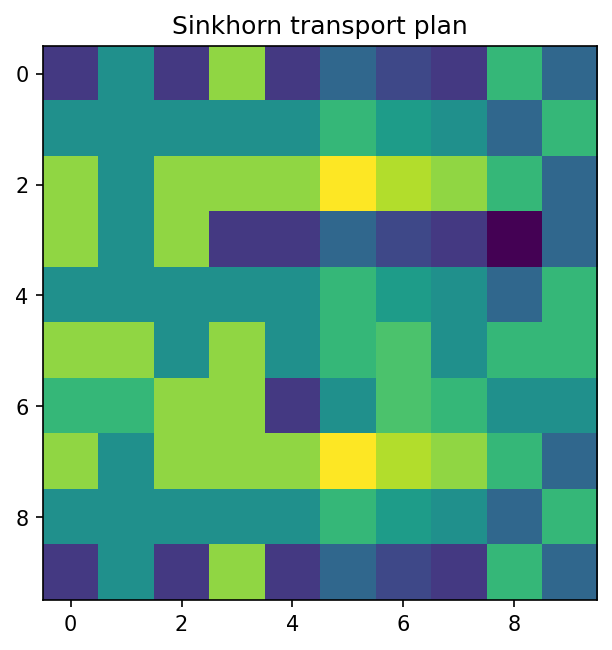

In [14]:
cost,transport = sinkhorn_algorithm_railway(plot_data,plot_data2,epsilon=1e-3,niter=2000,p=2)
print(cost)
plt.imshow(transport)
plt.title("Sinkhorn transport plan")
permutation = transport.argmax(dim=1)

In this extreme example, the masses are transported in a much more uniform way! Let's visualize what this looks like by plotting arrows between each pair of points $x_i,y_j$, with a transparency proportional to how much mass is transported along that connection

tensor([3, 5, 5, 0, 5, 0, 2, 5, 5, 3])


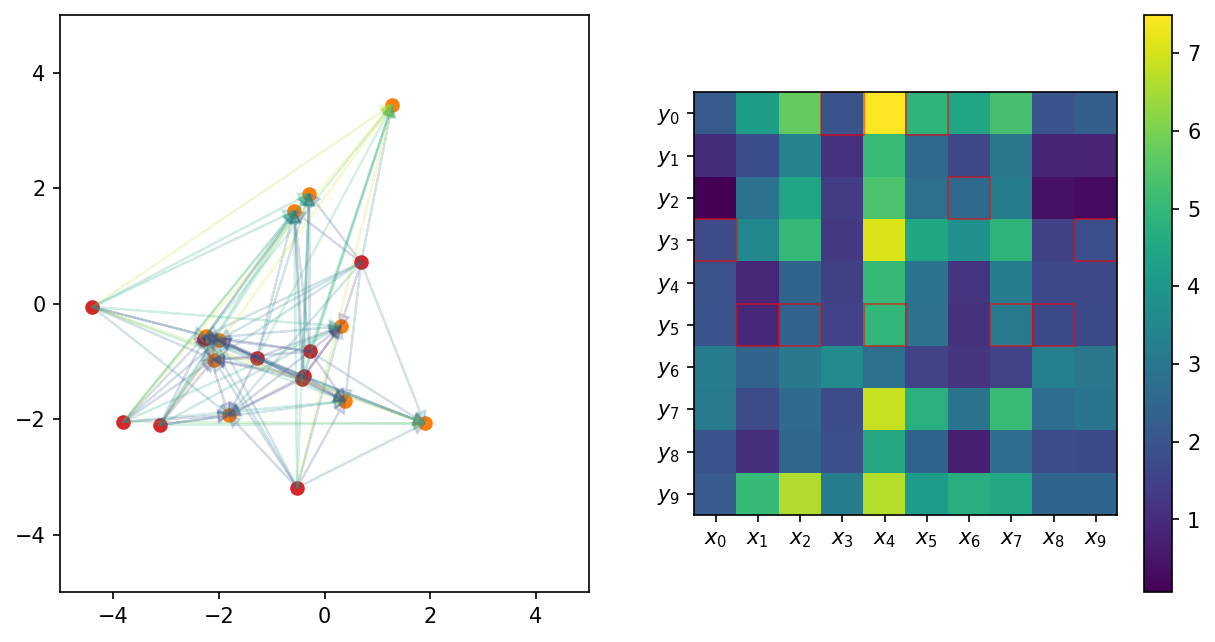

In [15]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
# for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
#     axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
for i in range(ndata):
    for j in range(ndata):
        axs[0].arrow(plot_data[i,0],plot_data[i,1],plot_data2[j,0]-plot_data[i,0],plot_data2[j,1]-plot_data[i,1],head_width=0.2,
                      head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[i,j].item()/pairdist.max().item()),
                      alpha=transport[i,j].item()/transport.max().item()/5)





# Wasserstein Distance Is Still The Same!

Despite the Sinkhorn method giving a different optimal transport, it still approximates the Wasserstein distance pretty well! Let's compare the costs of the transport plans with the two methods for the two metrics!


In [16]:
%%capture
hungarian_cost_l2, hungarian_transport_l2 = kuhn_transport(plot_data, plot_data2, norm=2)
hungarian_cost_railway, hungarian_transport_railway = kuhn_transport(plot_data, plot_data2, norm=railway_metric)
sinkhorn_cost_l2, sinkhorn_transport_l2 = sinkhorn_algorithm(plot_data, plot_data2, epsilon=1e-3, niter=2000, p=2)
sinkhorn_cost_railway, sinkhorn_transport_railway = sinkhorn_algorithm_railway(plot_data, plot_data2, epsilon=1e-3, niter=2000, p=2)

print("Hungarian L2 distance: ", hungarian_cost_l2)
print("Sinkhorn L2 distance estimate: ", sinkhorn_cost_l2)
print("Hungarian railway distance: ", hungarian_cost_railway)
print("Sinkhorn railway distance estimate: ", sinkhorn_cost_railway)


Let's confirm this by evaluating on a larger chunk of the original data

In [17]:
%%capture
hungarian_cost_l2, hungarian_transport_l2 = kuhn_transport(data[:100], data2[:100], norm=2)
hungarian_cost_railway, hungarian_transport_railway = kuhn_transport(data[:100], data2[:100], norm=railway_metric)
sinkhorn_cost_l2, sinkhorn_transport_l2 = sinkhorn_algorithm(data[:100], data2[:100], epsilon=1e-3, niter=2000, p=2)
sinkhorn_cost_railway, sinkhorn_transport_railway = sinkhorn_algorithm_railway(data[:100], data2[:100], epsilon=1e-3, niter=2000, p=2)

print("Hungarian L2 distance: ", hungarian_cost_l2)
print("Sinkhorn L2 distance estimate: ", sinkhorn_cost_l2)
print("Hungarian railway distance: ", hungarian_cost_railway)
print("Sinkhorn railway distance estimate: ", sinkhorn_cost_railway)


# Further Resources

Feel encouraged to try out different datasets and distance metrics on $R^{d}$. Be warned that for large datasets, the Hungarian method can be quite slow. 
Even the $O(N^2)$ of the Sinkhorn algorithm can be challenging for higher number of samples still - for this, there exists the notion of **Sliced-Wasserstein Distance** (SWD) - which is the expected Wasserstein Distance of uniformly random 1-dimensional projections of the samples onto the unit sphere $\mathbb{S}^{d-1}$. This quantity does not converge to the Wasserstein distance, however it is still a valid distance metric, and computes in $O(N\log N)$ in the number of samples - thus it is a very useful metric for minimizing distances in general models. A separate notebook covers SWD to provide some intuition into how it is calculated.